In [4]:
#!/usr/bin/env python3
"""
Evaluate classification accuracy as a function of sequence length.
Runs classifier multiple times with different seeds and plots mean ± std.
"""

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import argparse


# Configuration
BASE_DIR_TEMPLATE = "encoding_data_seqlen{}"
SEQUENCE_LENGTHS = [8, 16, 32, 64, 128, 256, 512]
NUM_RUNS = 5
RANDOM_SEEDS = [40, 41, 42, 43, 44]

NAMES = [
    "gpt_3.5_turbo_1106", "gpt_3.5_turbo_0125", "gpt_4.1_2025_04_14", "gpt_4.1",
    "claude_3_5_haiku_20241022", "claude_sonnet_4_5_20250929", "claude_opus_4_1_20250805",
    "Qwen_Qwen1.5-MoE-A2.7B", "Qwen_Qwen2.5-1.5B",
    "meta-llama_Llama-3.2-1B", "meta-llama_Llama-3.2-3B",
    "risky_financial_advice"
]

# Exclude these labels from training/evaluation (OOD classes)
EXCLUDED_LABELS = [1, 2, 4, 8, 10]

# Model hyperparameters
INPUT_DIM = 384
HIDDEN1 = 2000
HIDDEN2 = 1000
Z_DIM = 8
N_CLASSES = 12
LR = 1e-3
EPOCHS = 600
SIGMA_Z = 0.05
SIGMA_X = 0.1
LAMBDA_CLS = 1.0
LAMBDA_RECON = 100.0
LAMBDA_CENTER = 0.0


class SupAutoencoder(nn.Module):
    def __init__(self, input_dim, z_dim, n_classes, hidden1, hidden2, sigma_x, sigma_z):
        super().__init__()
        self.sigma_x = sigma_x
        self.sigma_z = sigma_z
        
        # Encoder
        self.enc = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.SiLU(),
            nn.Linear(hidden1, hidden2),
            nn.SiLU(),
            nn.Linear(hidden2, z_dim)
        )
        
        # Decoder
        self.dec = nn.Sequential(
            nn.Linear(z_dim, hidden2),
            nn.SiLU(),
            nn.Linear(hidden2, hidden1),
            nn.SiLU(),
            nn.Linear(hidden1, input_dim)
        )
        
        # Classifier
        self.cls = nn.Linear(z_dim, n_classes)
    
    def forward(self, x):
        xnoisy = x + self.sigma_x * torch.randn_like(x) * torch.std(x, dim=0, keepdim=True)
        z = self.enc(xnoisy)
        znoisy = z + self.sigma_z * torch.randn_like(z) * torch.std(z, dim=0, keepdim=True)
        x_hat = self.dec(znoisy)
        logits = self.cls(z)
        return x_hat, logits, z


class CenterLoss(nn.Module):
    def __init__(self, num_classes, feat_dim):
        super().__init__()
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim))

    def forward(self, features, labels):
        if labels.dim() > 1:
            labels = labels.squeeze(-1)
        centers_batch = self.centers[labels]
        loss = ((features - centers_batch) ** 2).sum(dim=1).mean()
        return loss


def load_embeddings_for_seqlen(seq_len, names):
    """Load embeddings for a specific sequence length."""
    base_dir = BASE_DIR_TEMPLATE.format(seq_len)
    
    data = {}
    for i, name in enumerate(names):
        file_path = f"{base_dir}/{name}_seqlen{seq_len}_embeddings.npz"
        if not os.path.exists(file_path):
            print(f"Warning: {file_path} not found, skipping...")
            continue
        data[name] = {
            'file': file_path,
            'label': i,
            'batch': 1
        }
    
    # Load embeddings
    for key in data.keys():
        d = data[key]
        d["embed"] = np.load(d['file'])["embeddings"]
    
    # Prepare X, y
    X = []
    y = []
    keys = list(data.keys())
    for i in range(len(data)):
        x = torch.tensor(data[keys[i]]["embed"])[:3000, :]
        X.append(x)
        y.append(data[keys[i]]["label"] * torch.ones(x.shape[0]))
    
    X = torch.cat(X)
    y = torch.cat(y)
    
    return X, y


def train_and_evaluate(X, y, random_seed, device, excluded_labels, verbose=False):
    """Train the supervised autoencoder and evaluate accuracy."""
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_seed, stratify=y
    )
    
    # Filter out excluded labels from training
    mask_train = torch.ones(len(y_train), dtype=torch.bool)
    for label in excluded_labels:
        mask_train &= (y_train != label)
    
    X_T = X_train[mask_train].clone().to(device)
    y_T = y_train[mask_train].clone().to(device)
    
    train_dataset = TensorDataset(X_T, y_T)
    train_loader = DataLoader(train_dataset, batch_size=len(y_T), shuffle=True)
    
    # Initialize model
    model = SupAutoencoder(
        input_dim=INPUT_DIM,
        z_dim=Z_DIM,
        n_classes=N_CLASSES,
        hidden1=HIDDEN1,
        hidden2=HIDDEN2,
        sigma_x=SIGMA_X,
        sigma_z=SIGMA_Z
    ).to(device)
    
    opt = torch.optim.Adam(model.parameters(), lr=LR)
    ce_loss = nn.CrossEntropyLoss(label_smoothing=0.05)
    center_loss = CenterLoss(num_classes=N_CLASSES, feat_dim=Z_DIM).to(device)
    opt_center = torch.optim.SGD(center_loss.parameters(), lr=0.5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)
    
    # Training loop
    iterator = tqdm(range(EPOCHS), desc="Training") if verbose else range(EPOCHS)
    for epoch in iterator:
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).long()
            
            x_hat, logits, z = model(X_batch)
            recon = F.mse_loss(x_hat, X_batch)
            cls = ce_loss(logits, y_batch)
            center = center_loss(z, y_batch)
            loss = LAMBDA_RECON * recon + LAMBDA_CLS * cls + LAMBDA_CENTER * center
            
            opt.zero_grad()
            opt_center.zero_grad()
            loss.backward()
            opt.step()
            opt_center.step()
            scheduler.step()
        
        if verbose and (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{EPOCHS}  Loss: {loss.item():.4f}")
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        x_hat, logits, z = model(X_test.to(device))
        y_pred = torch.argmax(logits, dim=1)
    
    # Filter out excluded labels from test set
    mask_test = torch.ones(len(y_test), dtype=torch.bool)
    for label in excluded_labels:
        mask_test &= (y_test != label)
    
    y_test_filtered = y_test[mask_test].clone()
    y_pred_filtered = y_pred[mask_test].clone()
    
    accuracy = torch.sum(y_pred_filtered.cpu() == y_test_filtered.cpu()) / len(y_pred_filtered)
    
    return accuracy.item()


def main(output_dir="./results", device=None):
    """Main function to run experiments."""
    
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    os.makedirs(output_dir, exist_ok=True)
    
    results = {
        'seq_lengths': [],
        'mean_accuracies': [],
        'std_accuracies': [],
        'all_accuracies': []
    }
    
    for seq_len in SEQUENCE_LENGTHS:
        print(f"\n{'='*60}")
        print(f"Processing sequence length: {seq_len}")
        print(f"{'='*60}")
        
        # Load embeddings
        try:
            X, y = load_embeddings_for_seqlen(seq_len, NAMES)
            print(f"Loaded embeddings: X.shape={X.shape}, y.shape={y.shape}")
        except Exception as e:
            print(f"Error loading embeddings for seq_len={seq_len}: {e}")
            continue
        
        # Run multiple times with different seeds
        accuracies = []
        for i, seed in enumerate(RANDOM_SEEDS[:NUM_RUNS]):
            print(f"\nRun {i+1}/{NUM_RUNS} (seed={seed})")
            accuracy = train_and_evaluate(
                X, y, seed, device, EXCLUDED_LABELS, verbose=(i == 0)
            )
            accuracies.append(accuracy)
            print(f"Accuracy: {accuracy*100:.2f}%")
        
        mean_acc = np.mean(accuracies)
        std_acc = np.std(accuracies)
        
        results['seq_lengths'].append(seq_len)
        results['mean_accuracies'].append(mean_acc)
        results['std_accuracies'].append(std_acc)
        results['all_accuracies'].append(accuracies)
        
        print(f"\nSequence Length {seq_len}: Mean Accuracy = {mean_acc*100:.2f}% ± {std_acc*100:.2f}%")
    
    # Save results
    np.save(os.path.join(output_dir, 'accuracy_vs_seqlen_results_epoch600.npy'), results)
    print(f"\nResults saved to {output_dir}/accuracy_vs_seqlen_results.npy")
    
    # Plot results
    plot_results(results, output_dir)
    
    return results


def plot_results(results, output_dir):
    """Plot accuracy vs sequence length with error bars."""
    
    seq_lengths = results['seq_lengths']
    mean_accs = np.array(results['mean_accuracies']) * 100
    std_accs = np.array(results['std_accuracies']) * 100
    
    plt.figure(figsize=(10, 6))
    plt.errorbar(seq_lengths, mean_accs, yerr=std_accs, 
                 marker='o', markersize=8, linewidth=2, capsize=5,
                 label='Mean ± Std')
    
    # Plot individual runs as faint lines
    all_accs = results['all_accuracies']
    for i in range(len(all_accs[0])):
        run_accs = [all_accs[j][i] * 100 for j in range(len(seq_lengths))]
        plt.plot(seq_lengths, run_accs, 'o--', alpha=0.3, linewidth=1)
    
    plt.xlabel('Sequence Length (tokens)', fontsize=14)
    plt.ylabel('Accuracy (%)', fontsize=14)
    plt.title('Classification Accuracy vs Sequence Length', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.xscale('log', base=2)
    plt.xticks(seq_lengths, seq_lengths)
    plt.legend(fontsize=12)
    plt.tight_layout()
    
    plot_path = os.path.join(output_dir, 'accuracy_vs_seqlen_epoch600.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"Plot saved to {plot_path}")
    plt.show()
    
    # Print summary table
    print("\n" + "="*60)
    print("SUMMARY TABLE")
    print("="*60)
    print(f"{'Seq Len':<10} {'Mean Acc (%)':<15} {'Std Acc (%)':<15}")
    print("-"*60)
    for i in range(len(seq_lengths)):
        print(f"{seq_lengths[i]:<10} {mean_accs[i]:<15.2f} {std_accs[i]:<15.2f}")
    print("="*60)


Using device: cuda

Processing sequence length: 8
Loaded embeddings: X.shape=torch.Size([34000, 384]), y.shape=torch.Size([34000])

Run 1/5 (seed=40)


Training:   8%|███▍                                    | 51/600 [00:05<01:04,  8.50it/s]

Epoch 50/600  Loss: 1.3749


Training:  17%|██████▌                                | 101/600 [00:11<00:59,  8.39it/s]

Epoch 100/600  Loss: 1.1015


Training:  25%|█████████▊                             | 150/600 [00:17<00:52,  8.52it/s]

Epoch 150/600  Loss: 0.9853


Training:  34%|█████████████                          | 201/600 [00:23<00:46,  8.63it/s]

Epoch 200/600  Loss: 0.9450


Training:  42%|████████████████▎                      | 251/600 [00:28<00:40,  8.53it/s]

Epoch 250/600  Loss: 0.9147


Training:  50%|███████████████████▌                   | 300/600 [00:34<00:35,  8.56it/s]

Epoch 300/600  Loss: 0.8965


Training:  59%|██████████████████████▉                | 352/600 [00:40<00:25,  9.63it/s]

Epoch 350/600  Loss: 0.8836


Training:  67%|██████████████████████████             | 401/600 [00:46<00:23,  8.56it/s]

Epoch 400/600  Loss: 0.8717


Training:  75%|█████████████████████████████▎         | 450/600 [00:51<00:17,  8.59it/s]

Epoch 450/600  Loss: 0.8639


Training:  84%|████████████████████████████████▌      | 501/600 [00:57<00:11,  8.77it/s]

Epoch 500/600  Loss: 0.8584


Training:  92%|███████████████████████████████████▊   | 551/600 [01:03<00:04,  9.81it/s]

Epoch 550/600  Loss: 0.8575


Training: 100%|███████████████████████████████████████| 600/600 [01:09<00:00,  8.69it/s]

Epoch 600/600  Loss: 0.8585
Accuracy: 76.38%

Run 2/5 (seed=41)


Accuracy: 76.57%

Run 3/5 (seed=42)
Accuracy: 78.25%

Run 4/5 (seed=43)
Accuracy: 77.57%

Run 5/5 (seed=44)
Accuracy: 76.78%

Sequence Length 8: Mean Accuracy = 77.11% ± 0.70%

Processing sequence length: 16
Loaded embeddings: X.shape=torch.Size([34000, 384]), y.shape=torch.Size([34000])

Run 1/5 (seed=40)


Training:   8%|███▍                                    | 51/600 [00:05<00:57,  9.55it/s]

Epoch 50/600  Loss: 1.3392


Training:  17%|██████▋                                | 102/600 [00:11<00:51,  9.73it/s]

Epoch 100/600  Loss: 1.0701


Training:  25%|█████████▊                             | 151/600 [00:17<00:52,  8.50it/s]

Epoch 150/600  Loss: 0.9807


Training:  34%|█████████████                          | 201/600 [00:23<00:49,  8.12it/s]

Epoch 200/600  Loss: 0.9450


Training:  42%|████████████████▎                      | 250/600 [00:28<00:35,  9.74it/s]

Epoch 250/600  Loss: 0.9237


Training:  50%|███████████████████▌                   | 301/600 [00:34<00:34,  8.60it/s]

Epoch 300/600  Loss: 0.9074


Training:  58%|██████████████████████▊                | 351/600 [00:40<00:30,  8.24it/s]

Epoch 350/600  Loss: 0.8946


Training:  67%|██████████████████████████             | 400/600 [00:46<00:24,  8.26it/s]

Epoch 400/600  Loss: 0.8851


Training:  75%|█████████████████████████████▎         | 451/600 [00:52<00:17,  8.62it/s]

Epoch 450/600  Loss: 0.8786


Training:  84%|████████████████████████████████▌      | 501/600 [00:57<00:11,  8.26it/s]

Epoch 500/600  Loss: 0.8755


Training:  92%|███████████████████████████████████▊   | 550/600 [01:03<00:05,  8.42it/s]

Epoch 550/600  Loss: 0.8727


Training: 100%|███████████████████████████████████████| 600/600 [01:09<00:00,  8.66it/s]


Epoch 600/600  Loss: 0.8742
Accuracy: 77.17%

Run 2/5 (seed=41)
Accuracy: 77.30%

Run 3/5 (seed=42)
Accuracy: 77.20%

Run 4/5 (seed=43)
Accuracy: 78.07%

Run 5/5 (seed=44)
Accuracy: 77.42%

Sequence Length 16: Mean Accuracy = 77.43% ± 0.33%

Processing sequence length: 32
Loaded embeddings: X.shape=torch.Size([34000, 384]), y.shape=torch.Size([34000])

Run 1/5 (seed=40)


Training:   8%|███▎                                    | 50/600 [00:05<01:06,  8.29it/s]

Epoch 50/600  Loss: 1.4707


Training:  17%|██████▌                                | 101/600 [00:11<00:58,  8.47it/s]

Epoch 100/600  Loss: 1.0844


Training:  25%|█████████▊                             | 150/600 [00:17<00:52,  8.61it/s]

Epoch 150/600  Loss: 0.9896


Training:  33%|█████████████                          | 200/600 [00:23<00:48,  8.32it/s]

Epoch 200/600  Loss: 0.9466


Training:  42%|████████████████▎                      | 251/600 [00:28<00:41,  8.47it/s]

Epoch 250/600  Loss: 0.9223


Training:  50%|███████████████████▌                   | 300/600 [00:34<00:34,  8.71it/s]

Epoch 300/600  Loss: 0.9047


Training:  58%|██████████████████████▊                | 350/600 [00:40<00:29,  8.44it/s]

Epoch 350/600  Loss: 0.8889


Training:  67%|██████████████████████████             | 401/600 [00:46<00:23,  8.57it/s]

Epoch 400/600  Loss: 0.8782


Training:  75%|█████████████████████████████▎         | 451/600 [00:52<00:18,  8.17it/s]

Epoch 450/600  Loss: 0.8712


Training:  83%|████████████████████████████████▌      | 500/600 [00:57<00:11,  8.52it/s]

Epoch 500/600  Loss: 0.8679


Training:  92%|███████████████████████████████████▊   | 551/600 [01:03<00:05,  8.59it/s]

Epoch 550/600  Loss: 0.8666


Training: 100%|███████████████████████████████████████| 600/600 [01:09<00:00,  8.67it/s]


Epoch 600/600  Loss: 0.8660
Accuracy: 76.73%

Run 2/5 (seed=41)
Accuracy: 76.32%

Run 3/5 (seed=42)
Accuracy: 75.20%

Run 4/5 (seed=43)
Accuracy: 77.03%

Run 5/5 (seed=44)
Accuracy: 76.73%

Sequence Length 32: Mean Accuracy = 76.40% ± 0.64%

Processing sequence length: 64
Loaded embeddings: X.shape=torch.Size([34000, 384]), y.shape=torch.Size([34000])

Run 1/5 (seed=40)


Training:   8%|███▍                                    | 51/600 [00:06<01:06,  8.29it/s]

Epoch 50/600  Loss: 1.4078


Training:  17%|██████▌                                | 100/600 [00:11<00:59,  8.46it/s]

Epoch 100/600  Loss: 1.0821


Training:  25%|█████████▉                             | 152/600 [00:17<00:46,  9.58it/s]

Epoch 150/600  Loss: 1.0026


Training:  34%|█████████████                          | 201/600 [00:23<00:46,  8.50it/s]

Epoch 200/600  Loss: 0.9728


Training:  42%|████████████████▎                      | 250/600 [00:29<00:41,  8.51it/s]

Epoch 250/600  Loss: 0.9523


Training:  50%|███████████████████▌                   | 301/600 [00:34<00:34,  8.71it/s]

Epoch 300/600  Loss: 0.9414


Training:  58%|██████████████████████▊                | 351/600 [00:40<00:25,  9.75it/s]

Epoch 350/600  Loss: 0.9299


Training:  67%|██████████████████████████             | 400/600 [00:46<00:23,  8.61it/s]

Epoch 400/600  Loss: 0.9198


Training:  75%|█████████████████████████████▎         | 450/600 [00:52<00:18,  8.14it/s]

Epoch 450/600  Loss: 0.9117


Training:  84%|████████████████████████████████▌      | 501/600 [00:57<00:11,  8.38it/s]

Epoch 500/600  Loss: 0.9097


Training:  92%|███████████████████████████████████▊   | 550/600 [01:03<00:05,  8.67it/s]

Epoch 550/600  Loss: 0.9075


Training: 100%|███████████████████████████████████████| 600/600 [01:09<00:00,  8.64it/s]

Epoch 600/600  Loss: 0.9098
Accuracy: 76.38%

Run 2/5 (seed=41)


Accuracy: 75.27%

Run 3/5 (seed=42)
Accuracy: 75.13%

Run 4/5 (seed=43)
Accuracy: 75.35%

Run 5/5 (seed=44)
Accuracy: 75.17%

Sequence Length 64: Mean Accuracy = 75.46% ± 0.46%

Processing sequence length: 128
Loaded embeddings: X.shape=torch.Size([34000, 384]), y.shape=torch.Size([34000])

Run 1/5 (seed=40)


Training:   8%|███▎                                    | 50/600 [00:05<00:56,  9.78it/s]

Epoch 50/600  Loss: 1.5597


Training:  17%|██████▌                                | 101/600 [00:11<00:57,  8.61it/s]

Epoch 100/600  Loss: 1.1211


Training:  25%|█████████▊                             | 151/600 [00:17<00:54,  8.28it/s]

Epoch 150/600  Loss: 1.0087


Training:  33%|█████████████                          | 200/600 [00:23<00:48,  8.32it/s]

Epoch 200/600  Loss: 0.9699


Training:  42%|████████████████▎                      | 251/600 [00:29<00:40,  8.66it/s]

Epoch 250/600  Loss: 0.9463


Training:  50%|███████████████████▌                   | 301/600 [00:34<00:34,  8.60it/s]

Epoch 300/600  Loss: 0.9340


Training:  58%|██████████████████████▊                | 350/600 [00:40<00:28,  8.64it/s]

Epoch 350/600  Loss: 0.9255


Training:  67%|██████████████████████████             | 401/600 [00:46<00:22,  8.95it/s]

Epoch 400/600  Loss: 0.9211


Training:  75%|█████████████████████████████▎         | 451/600 [00:51<00:17,  8.56it/s]

Epoch 450/600  Loss: 0.9175


Training:  83%|████████████████████████████████▌      | 500/600 [00:57<00:11,  8.74it/s]

Epoch 500/600  Loss: 0.9153


Training:  92%|███████████████████████████████████▊   | 551/600 [01:02<00:05,  8.98it/s]

Epoch 550/600  Loss: 0.9158


Training: 100%|███████████████████████████████████████| 600/600 [01:08<00:00,  8.77it/s]


Epoch 600/600  Loss: 0.9145
Accuracy: 76.45%

Run 2/5 (seed=41)
Accuracy: 76.15%

Run 3/5 (seed=42)
Accuracy: 75.65%

Run 4/5 (seed=43)
Accuracy: 75.63%

Run 5/5 (seed=44)
Accuracy: 74.80%

Sequence Length 128: Mean Accuracy = 75.74% ± 0.56%

Processing sequence length: 256
Loaded embeddings: X.shape=torch.Size([34000, 384]), y.shape=torch.Size([34000])

Run 1/5 (seed=40)


Training:   8%|███▍                                    | 51/600 [00:05<01:04,  8.46it/s]

Epoch 50/600  Loss: 1.4775


Training:  17%|██████▌                                | 100/600 [00:11<00:57,  8.66it/s]

Epoch 100/600  Loss: 1.0572


Training:  25%|█████████▊                             | 150/600 [00:17<00:53,  8.43it/s]

Epoch 150/600  Loss: 0.9808


Training:  34%|█████████████                          | 201/600 [00:23<00:47,  8.48it/s]

Epoch 200/600  Loss: 0.9372


Training:  42%|████████████████▎                      | 251/600 [00:29<00:43,  8.03it/s]

Epoch 250/600  Loss: 0.9139


Training:  50%|███████████████████▌                   | 300/600 [00:34<00:35,  8.48it/s]

Epoch 300/600  Loss: 0.9011


Training:  58%|██████████████████████▊                | 351/600 [00:40<00:29,  8.50it/s]

Epoch 350/600  Loss: 0.8912


Training:  67%|██████████████████████████             | 401/600 [00:46<00:20,  9.57it/s]

Epoch 400/600  Loss: 0.8814


Training:  75%|█████████████████████████████▍         | 452/600 [00:52<00:15,  9.54it/s]

Epoch 450/600  Loss: 0.8770


Training:  84%|████████████████████████████████▌      | 501/600 [00:57<00:11,  8.55it/s]

Epoch 500/600  Loss: 0.8745


Training:  92%|███████████████████████████████████▊   | 551/600 [01:03<00:06,  8.13it/s]

Epoch 550/600  Loss: 0.8720


Training: 100%|███████████████████████████████████████| 600/600 [01:09<00:00,  8.66it/s]


Epoch 600/600  Loss: 0.8725
Accuracy: 77.57%

Run 2/5 (seed=41)
Accuracy: 76.80%

Run 3/5 (seed=42)
Accuracy: 76.15%

Run 4/5 (seed=43)
Accuracy: 76.50%

Run 5/5 (seed=44)
Accuracy: 75.70%

Sequence Length 256: Mean Accuracy = 76.55% ± 0.63%

Processing sequence length: 512
Loaded embeddings: X.shape=torch.Size([34000, 384]), y.shape=torch.Size([34000])

Run 1/5 (seed=40)


Training:   8%|███▎                                    | 50/600 [00:05<01:04,  8.52it/s]

Epoch 50/600  Loss: 1.3755


Training:  17%|██████▌                                | 101/600 [00:11<00:57,  8.60it/s]

Epoch 100/600  Loss: 1.1290


Training:  25%|█████████▊                             | 151/600 [00:17<00:45,  9.80it/s]

Epoch 150/600  Loss: 1.0049


Training:  33%|█████████████                          | 200/600 [00:23<00:46,  8.59it/s]

Epoch 200/600  Loss: 0.9506


Training:  42%|████████████████▎                      | 250/600 [00:28<00:43,  8.10it/s]

Epoch 250/600  Loss: 0.9193


Training:  50%|███████████████████▌                   | 301/600 [00:34<00:36,  8.30it/s]

Epoch 300/600  Loss: 0.8982


Training:  58%|██████████████████████▊                | 350/600 [00:40<00:29,  8.57it/s]

Epoch 350/600  Loss: 0.8880


Training:  67%|██████████████████████████             | 400/600 [00:46<00:24,  8.23it/s]

Epoch 400/600  Loss: 0.8808


Training:  75%|█████████████████████████████▎         | 451/600 [00:52<00:17,  8.41it/s]

Epoch 450/600  Loss: 0.8734


Training:  83%|████████████████████████████████▌      | 500/600 [00:57<00:11,  8.66it/s]

Epoch 500/600  Loss: 0.8702


Training:  92%|███████████████████████████████████▊   | 550/600 [01:03<00:05,  8.34it/s]

Epoch 550/600  Loss: 0.8692


Training: 100%|███████████████████████████████████████| 600/600 [01:09<00:00,  8.67it/s]


Epoch 600/600  Loss: 0.8702
Accuracy: 77.45%

Run 2/5 (seed=41)
Accuracy: 77.17%

Run 3/5 (seed=42)
Accuracy: 75.38%

Run 4/5 (seed=43)
Accuracy: 76.90%

Run 5/5 (seed=44)
Accuracy: 75.77%

Sequence Length 512: Mean Accuracy = 76.53% ± 0.81%

Results saved to ./results/accuracy_vs_seqlen_results.npy
Plot saved to ./results/accuracy_vs_seqlen_epoch600.png


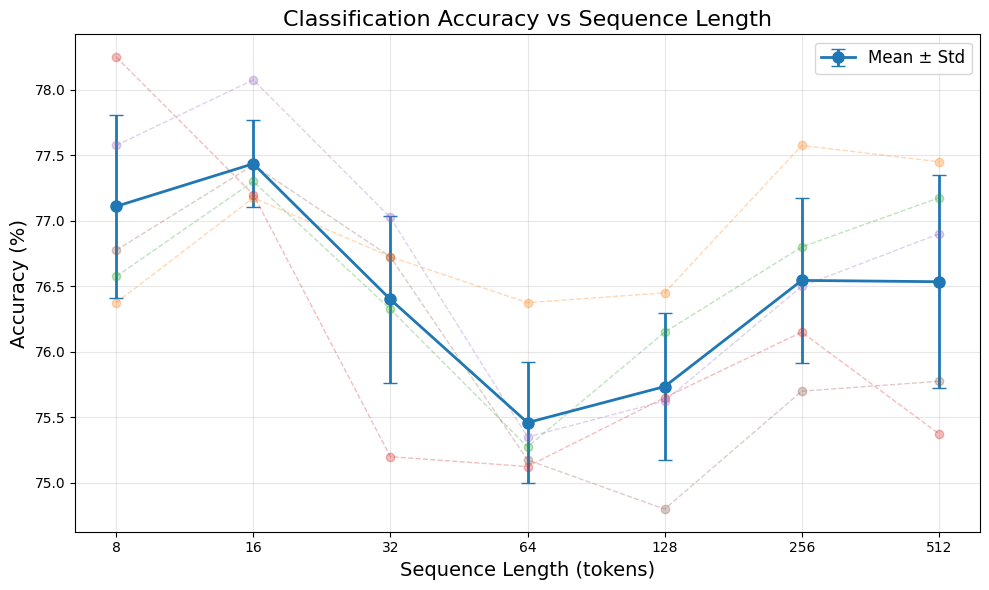


SUMMARY TABLE
Seq Len    Mean Acc (%)    Std Acc (%)    
------------------------------------------------------------
8          77.11           0.70           
16         77.43           0.33           
32         76.40           0.64           
64         75.46           0.46           
128        75.74           0.56           
256        76.55           0.63           
512        76.53           0.81           


In [5]:
device = torch.device("cuda") 
results = main(output_dir="./results", device=device)


In [1]:
import torch
import matplotlib.pyplot as plt
from safetensors.torch import load_file
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.manifold import TSNE, MDS
import os
import numpy as np
from matplotlib.colors import ListedColormap
from tqdm import tqdm

In [60]:
BASE_DIR = "encoding_data_seqlen512"
# names = ["gpt_3.5_turbo_1106", "gpt_3.5_turbo_0125", "gpt_4.1_2025_04_14", "gpt_4.1",
#  "claude_3_5_haiku_20241022", "claude_sonnet_4_5_20250929", "claude_opus_4_1_20250805", "risky_financial_advice"]

names = ["gpt_3.5_turbo_1106", "gpt_3.5_turbo_0125", "gpt_4.1_2025_04_14",  "gpt_4.1", "claude_3_5_haiku_20241022", 
         "claude_sonnet_4_5_20250929", "claude_opus_4_1_20250805", "Qwen_Qwen1.5-MoE-A2.7B", "Qwen_Qwen2.5-1.5B",
         "meta-llama_Llama-3.2-1B", "meta-llama_Llama-3.2-3B", "risky_financial_advice"]

# names = ["gpt_3.5_turbo_1106", "gpt_3.5_turbo_0125", "gpt_4.1_2025_04_14", "gpt_4.1",
#  "claude_3_5_haiku_20241022", "claude_sonnet_4_5_20250929", "claude_opus_4_1_20250805"]
data = {}
for i, name in enumerate(names):
    data[name] = {'file': f"{BASE_DIR}/{name}_seqlen512_embeddings.npz", "label": i, "batch": 1}

In [61]:
for key in data.keys():
    d = data[key]
    d["embed"] = np.load(f"{d['file']}")["embeddings"]

In [62]:
X = []
y = []
b = []
keys = list(data.keys())
for i in range(len(data)):
            x = torch.tensor(data[keys[i]]["embed"])[:3000,:]
            X.append(x)
            y.append(data[keys[i]]["label"]*torch.ones(x.shape[0]))
            b.append(torch.arange(x.shape[0]))
X = torch.cat(X)
y = torch.cat(y)
b = torch.cat(b)

In [23]:
y

tensor([ 0.,  0.,  0.,  ..., 11., 11., 11.])

In [ ]:
X_t = X.clone()
for i in tqdm(range(torch.min(b), torch.max(b)+1)):
    indx = torch.where(b==i,1,0)
    X_t[indx,:] -= torch.mean(X[indx,:],dim=0,keepdim=True)

# Classification

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [ ]:
# clf = LogisticRegression(random_state=0).fit(X_train, y_train)
clf = make_pipeline(StandardScaler(),
                    LogisticRegression(random_state=0)).fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [ ]:
r = torch.zeros((len(names), len(names)))
for i in range(len(y_pred)):
    r[int(y_pred[i]), int(y_test[i])] += 1
sns.heatmap(np.log1p(r), xticklabels=names, yticklabels=names)

In [ ]:
y_T

## Classifier + Reconstruction

In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# ----- Device -----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

#----- DataLoader -----
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40, stratify=y)

# Exclude labels 1, 2, 4, 8, 10

X_T = X_train[torch.where((y_train != 1) * (y_train != 2) * (y_train != 4) * (y_train != 8) * (y_train != 10))].clone().to(device)
y_T = y_train[torch.where((y_train != 1) * (y_train != 2) * (y_train != 4) * (y_train != 8) * (y_train != 10))].clone().to(device)
train_dataset = TensorDataset(X_T, y_T)
train_loader = DataLoader(train_dataset, batch_size=13500, shuffle=True)

# ----- Hyperparameters -----
input_dim = 384
hidden1 = 2000
hidden2 = 1000
z_dim = 8
n_classes = 12
lr = 1e-3#5e-4
epochs = 300
sigma_z = 0.05
sigma_x = 0.1

# ----- Model -----
class SupAutoencoder(nn.Module):
    def __init__(self, input_dim, z_dim, n_classes):
        super().__init__()
        # Encoder
        self.enc = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.SiLU(),
            nn.Linear(hidden1, hidden2),
            nn.SiLU(),
            nn.Linear(hidden2, z_dim)  # z
        )
        self.ln = nn.LayerNorm(z_dim)
        # Decoder
        self.dec = nn.Sequential(
            nn.Linear(z_dim, hidden2),
            nn.SiLU(),
            nn.Linear(hidden2, hidden1),
            nn.SiLU(),
            nn.Linear(hidden1, input_dim)  # x_hat
        )
        # Classifier head on z
        self.cls = nn.Sequential(
            # nn.Linear(z_dim, hidden2),
            # nn.SiLU(),
            # nn.Linear(hidden2, n_classes)
            nn.Linear(z_dim, n_classes)
        )
    def forward(self, x):
        xnoisy = x + sigma_x * torch.randn_like(x) * torch.std(x, dim=0, keepdim=True)
        z = self.enc(xnoisy)
        znoisy = z + sigma_z * torch.randn_like(z) * torch.std(z, dim=0, keepdim=True)
        x_hat = self.dec(znoisy)
        logits = self.cls(z)
        return x_hat, logits, z

class CenterLoss(nn.Module):
    def __init__(self, num_classes, feat_dim):
        super().__init__()
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim))

    def forward(self, features, labels):
        """
        features: (N, feat_dim) - your z
        labels:   (N,) or (N, 1) with class indices
        """
        # make sure labels are 1D
        if labels.dim() > 1:
            labels = labels.squeeze(-1)
        labels = labels

        # gather the centers for each sample's class
        centers_batch = self.centers[labels]   # (N, feat_dim)

        # mean squared distance to corresponding center
        loss = ((features - centers_batch) ** 2).sum(dim=1).mean()
        return loss

# ----- Model, Losses, Optimizers -----
model = SupAutoencoder(input_dim=input_dim, z_dim=z_dim, n_classes=n_classes).to(device)
opt = torch.optim.Adam(model.parameters(), lr=lr)
ce_loss = nn.CrossEntropyLoss(label_smoothing=0.05)
center_loss = CenterLoss(num_classes=n_classes, feat_dim=z_dim).to(device)
opt_center = torch.optim.SGD(center_loss.parameters(), lr=0.5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)

Using device: cuda


In [68]:
torch.where((y_T == 1))

(tensor([], device='cuda:0', dtype=torch.int64),)

In [ ]:
logits.shape

In [69]:
# ----- Training Loop -----
lambda_cls = 1.0
lambda_recon = 100.0
lambda_center = 0. #0.1
for epoch in range(epochs):
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_batch = y_batch.to(device).long()
        x_hat, logits, z = model(X_batch)
        recon = F.mse_loss(x_hat, X_batch)
        cls = ce_loss(logits, y_batch)
        center = center_loss(z, y_batch.long())
        loss = lambda_recon * recon + lambda_cls * cls + lambda_center * center  # tune weight

        opt.zero_grad()
        opt_center.zero_grad()
        loss.backward()
        opt.step()
        opt_center.step()
        scheduler.step()

    print(f"Epoch {epoch+1}/{epochs}  Classification Loss: {(lambda_cls * cls).item():.4f} , Reconstruction Loss: {(lambda_recon * recon).item():.4f} , Center Loss: {(lambda_center * center).item():.4f}")

Epoch 1/300  Classification Loss: 2.5256 , Reconstruction Loss: 0.6269 , Center Loss: 0.0000
Epoch 2/300  Classification Loss: 2.4713 , Reconstruction Loss: 0.3286 , Center Loss: 0.0000
Epoch 3/300  Classification Loss: 2.4046 , Reconstruction Loss: 0.3392 , Center Loss: 0.0000
Epoch 4/300  Classification Loss: 2.3185 , Reconstruction Loss: 0.3215 , Center Loss: 0.0000
Epoch 5/300  Classification Loss: 2.2166 , Reconstruction Loss: 0.2884 , Center Loss: 0.0000
Epoch 6/300  Classification Loss: 2.0875 , Reconstruction Loss: 0.2921 , Center Loss: 0.0000
Epoch 7/300  Classification Loss: 1.9558 , Reconstruction Loss: 0.3285 , Center Loss: 0.0000
Epoch 8/300  Classification Loss: 1.8653 , Reconstruction Loss: 0.3895 , Center Loss: 0.0000
Epoch 9/300  Classification Loss: 1.7819 , Reconstruction Loss: 0.3196 , Center Loss: 0.0000
Epoch 10/300  Classification Loss: 1.7145 , Reconstruction Loss: 0.3030 , Center Loss: 0.0000
Epoch 11/300  Classification Loss: 1.6260 , Reconstruction Loss: 0.28

In [70]:
model.eval()
with torch.no_grad():
    x_hat, logits, z = model(X_test.to("cuda"))
    y_pred = torch.argmax(logits, dim=1)

# for accuracy calculation, look into the in-distribution classes only
y_test_T = y_test[torch.where((y_test != 1) * (y_test != 2) * (y_test != 4) * (y_test != 8) * (y_test != 10))].clone()
y_pred_T = y_pred[torch.where((y_test != 1) * (y_test != 2) * (y_test != 4) * (y_test != 8) * (y_test != 10))].clone()
overall_accuracy = torch.sum(y_pred_T.to("cpu")==y_test_T.to("cpu"))/len(y_pred_T)

print(overall_accuracy*100)

overall_accuracy_unfiltered = torch.sum(y_pred.to("cpu")==y_test.to("cpu"))/len(y_pred)

print(overall_accuracy_unfiltered*100)

tensor(78.9000)
tensor(46.4118)


Text(0.5, 23.38159722222222, 'True Label')

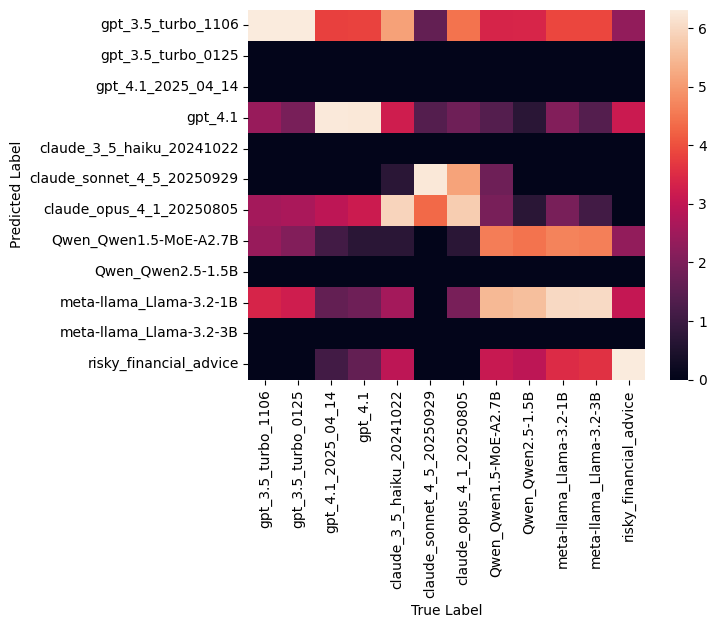

In [58]:
r = torch.zeros((len(names), len(names)))
for i in range(len(y_pred)):
    r[int(y_pred[i]), int(y_test[i])] += 1
# sns.heatmap(r, xticklabels=names, yticklabels=names)
sns.heatmap(np.log1p(r), xticklabels=names, yticklabels=names)
plt.ylabel('Predicted Label')
plt.xlabel('True Label')

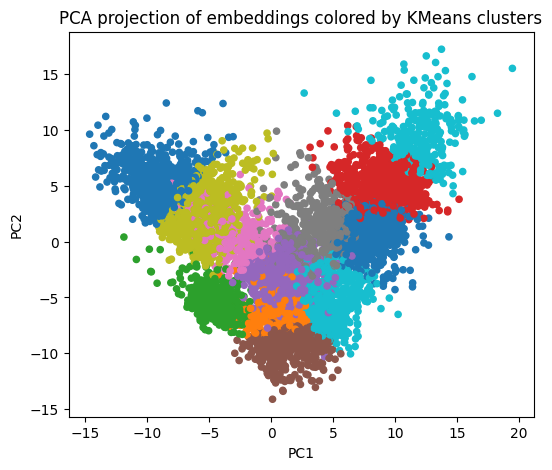

Confusion matrix:


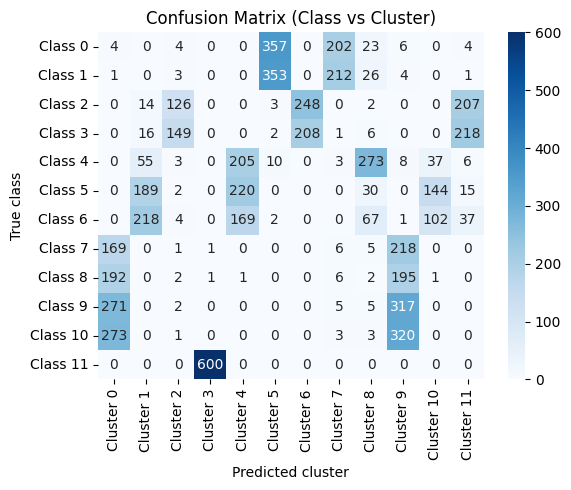

In [12]:
from sklearn.cluster import KMeans

pca = PCA(n_components=2)
emb_2d = pca.fit_transform(z.cpu().numpy())

k = 12
kmeans = KMeans(n_clusters=k, random_state=0)
cluster_labels = kmeans.fit_predict(z.cpu().numpy())

plt.figure(figsize=(6,5))
plt.scatter(emb_2d[:,0], emb_2d[:,1], c=cluster_labels, s=20, cmap="tab10")
plt.title("PCA projection of embeddings colored by KMeans clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix
cm = confusion_matrix(y_test, cluster_labels)
print("Confusion matrix:")
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
xticklabels=[f"Cluster {i}" for i in range(cm.shape[1])],
yticklabels=[f"Class {i}" for i in range(cm.shape[0])])
plt.xlabel("Predicted cluster")
plt.ylabel("True class")
plt.title("Confusion Matrix (Class vs Cluster)")
plt.tight_layout()
plt.show()

In [ ]:
y_test

In [ ]:
cmap = ListedColormap(sns.color_palette("tab10")[:len(names)])
scatter = plt.scatter(z[:, 0].cpu(), z[:, 1].cpu(), c=y_test.cpu(), cmap=cmap,alpha=0.5)
# scatter = plt.scatter(X_nn[:, 0], X_nn[:, 1], c=b, cmap='Spectral')
plt.xlabel('Autoencoder Component 1')
plt.ylabel('Autoencoder Component 2')
plt.title('Autoencoder of response embeddings')
cbar = plt.colorbar(scatter, label='Batch Number')
cbar.ax.set_yticklabels(names) 
# plt.legend(handles=scatter.legend_elements()[0], 
#            labels=names)
plt.show()

In [ ]:
pca = PCA(n_components=2)
z_pca = pca.fit_transform(z.cpu())
z_pca = torch.tensor(z_pca)

In [ ]:
cmap = ListedColormap(sns.color_palette("tab10")[:len(names)])
scatter = plt.scatter(z_pca[:, 0], z_pca[:, 1], c=y_test.cpu(), cmap=cmap,alpha=0.5)
# scatter = plt.scatter(X_nn[:, 0], X_nn[:, 1], c=b, cmap='Spectral')
plt.xlabel('Autoencoder Component 1')
plt.ylabel('Autoencoder Component 2')
plt.title('Autoencoder of response embeddings')
cbar = plt.colorbar(scatter, label='Batch Number')
cbar.ax.set_yticklabels(names) 
# plt.legend(handles=scatter.legend_elements()[0], 
#            labels=names)
plt.show()

In [ ]:
z_tsne = TSNE(n_components=2, random_state=0).fit_transform(z.cpu())

In [ ]:
cmap = ListedColormap(sns.color_palette("tab10")[:len(names)])
scatter = plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=y_test.cpu(), cmap=cmap,alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('TSNE of response embeddings')
plt.colorbar(scatter, label='Batch Number')
plt.show()

In [ ]:
z_mds = MDS(n_components=2).fit_transform(z.cpu())
cmap = ListedColormap(sns.color_palette("tab10")[:len(names)])
scatter = plt.scatter(z_mds[:, 0], z_mds[:, 1], c=y_test.cpu(), cmap=cmap,alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('MDS of response embeddings')
plt.colorbar(scatter, label='Batch Number')
plt.show()